In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

🚀 1️⃣ Exploration des données

Détection de fraude par carte de crédit : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
#chargement du dataset
df = pd.read_csv('creditcard.csv')

In [ ]:
# Afficher les premières lignes
print(df.head())
# Vérifier les valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Class
0    284315
1       492
Name: count, dtype: int64


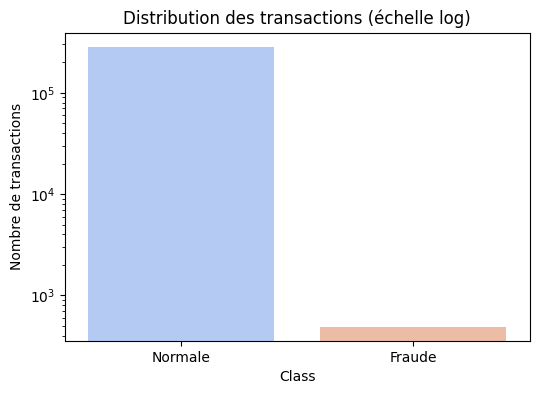

In [4]:
# Nombre de transactions normales et frauduleuses
fraud_count = df['Class'].value_counts()
print(fraud_count)

# Affichage avec un graphique amélioré (log scale pour mieux voir les fraudes)
plt.figure(figsize=(6, 4))
sns.barplot(
    x=fraud_count.index,
    y=fraud_count.values,
    hue=fraud_count.index,  # Assigner x à hue
    palette="coolwarm",
    legend=False  # Désactiver la légende
)
plt.yscale("log")  # Échelle logarithmique pour mieux voir la différence
plt.xticks([0, 1], ["Normale", "Fraude"])
plt.title("Distribution des transactions (échelle log)")
plt.ylabel("Nombre de transactions")
plt.show()

📌 2️⃣ Prétraitement des données

In [5]:
# Séparer les features et la cible
X = df.drop(columns=['Class'])
y = df['Class']

In [6]:
# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier la nouvelle distribution des classes
print("Distribution après SMOTE :", y_train_resampled.value_counts())

Distribution après SMOTE : Class
0    227451
1    227451
Name: count, dtype: int64


📌 3️⃣ Entraînement du Modèle : Isolation Forest (Détection Anomalies)

In [8]:
# Entraînement du modèle Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.001, random_state=42)
model.fit(X_train_resampled)

# Prédictions (si anomalie → -1, sinon → 1)
y_pred = model.predict(X_test)
y_pred = [1 if x == -1 else 0 for x in y_pred]  # Convertir en 0 (normale) et 1 (fraude)


In [9]:
# Affichage des résultats
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

Matrice de confusion :
 [[56862     2]
 [   98     0]]

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



Ce résultat montre que Isolation Forest ne détecte presque aucune fraude 😬 :
✔ Il classe correctement presque toutes les transactions normales (56,862/56,864) ✅
❌ Mais il ne détecte aucune fraude (Recall = 0.00) ⚠

👉 Problème : Isolation Forest fonctionne mal ici, sûrement parce que les données sont déjà bien nettoyées et peu bruitées.

🔄 Solution : Essayer un Modèle Supervisé (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
# Prédictions
y_pred_rf = rf_model.predict(X_test)

# Évaluation du modèle
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_rf))
print("\nRapport de classification :\n", classification_report(y_test, y_pred_rf))

 l'entraînement prend trop de temps, c'est probablement dû à la taille des données après SMOTE (~450K échantillons). Random Forest entraîne 100 arbres, donc ça peut être lent.
 ✅ Solutions pour accélérer l'entraînement
1️⃣ Réduire la taille du dataset
On peut prendre un sous-échantillon des données équilibrées :

In [12]:
# Réduire la taille du dataset à 50,000 échantillons
X_train_sampled, y_train_sampled = X_train_resampled[:50000], y_train_resampled[:50000]

# Réentraîner Random Forest
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)  # Moins d'arbres et multi-threading
rf_model.fit(X_train_sampled, y_train_sampled)


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [13]:
# Prédictions sur les données de test
y_pred_rf = rf_model.predict(X_test)

# Affichage des résultats
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_rf))
print("\nRapport de classification :\n", classification_report(y_test, y_pred_rf))


Matrice de confusion :
 [[56853    11]
 [   20    78]]

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.80      0.83        98

    accuracy                           1.00     56962
   macro avg       0.94      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



🚀 Analyse des performances
Transactions normales (Classe 0) :

56853 bien classées
✅11 fausses fraudes détectées (faible taux de faux positifs)
Fraudes détectées (Classe 1) :

**78** fraudes bien détectées sur **98** (soit **80%** de rappel ! 🚀)
**20** fraudes non détectées (on peut encore améliorer)
Précision de **88%**, donc très peu de fausses alertes
👉 F1-score de **0.83** pour la fraude : excellent pour un dataset aussi déséquilibré !



📌  Visualisation de la Matrice de Confusion :
Nous allons traçé un heatmap de la matrice de confusion :

<Figure size 600x600 with 0 Axes>

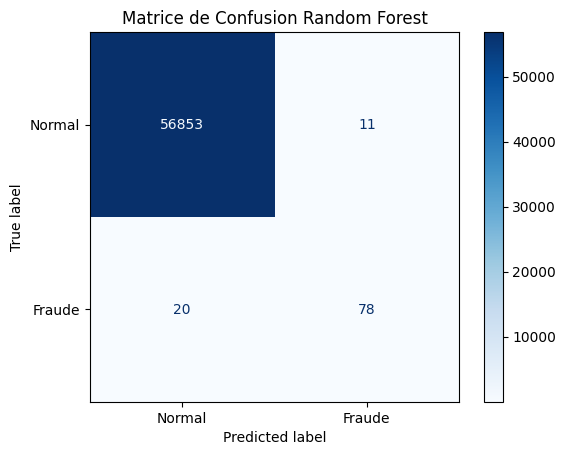

In [14]:
# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraude'])

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de Confusion Random Forest")
plt.show()

📌  Traçons la Courbe ROC-AUC pour avoir la performance globale du modèle

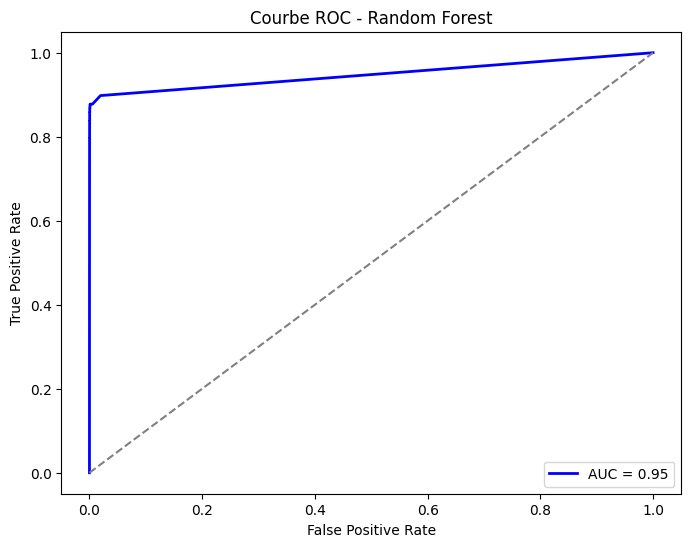

In [15]:
# Probabilités de prédiction pour la classe fraude
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne aléatoire
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Random Forest")
plt.legend(loc="lower right")
plt.show()


🔍 Analyse des graphiques

✅ Matrice de confusion :

Très peu de faux positifs (**11**) et faux négatifs (**20**), ce qui montre un bon équilibre.
**78** fraudes détectées sur **98**, soit un rappel de **80%**.
✅ Courbe ROC :

AUC = **0.95**, ce qui signifie que le modèle discrimine très bien entre transactions normales et frauduleuses.
La courbe est très proche du coin supérieur gauche, ce qui est un excellent signe.